In [3]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import tqdm

In [4]:
import skimage

def binarize(img, thr=8):
    smooth = skimage.filters.gaussian(img, 10)
    return (img > smooth) & (img > thr)

In [5]:
img1 = np.mean(imageio.imread("./images/P1110843.JPG"), axis=2)
img2 = np.mean(imageio.imread("./images/P1110844.JPG"), axis=2)

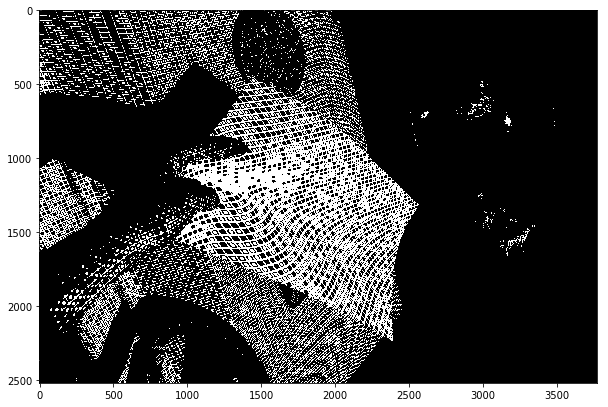

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(img1 > 80, cm.gray)

In [7]:
b_img1 = binarize(img1)

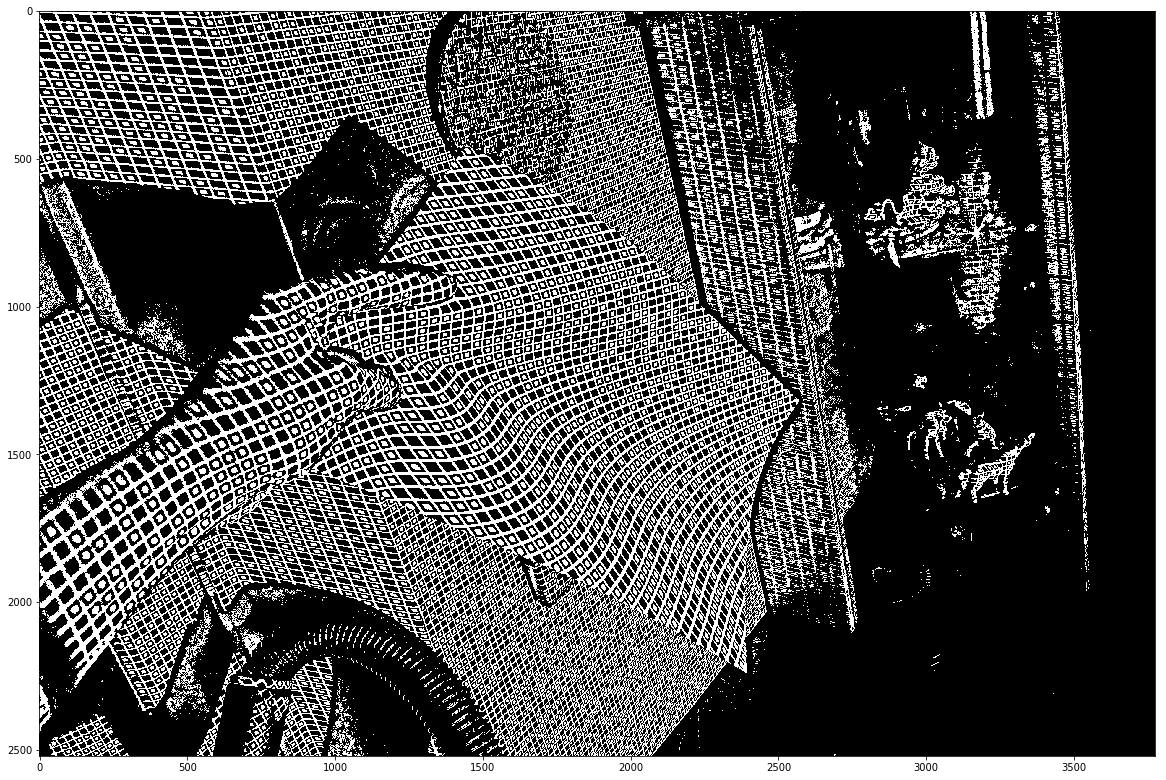

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(b_img1, cm.gray)

In [9]:
from skimage import morphology

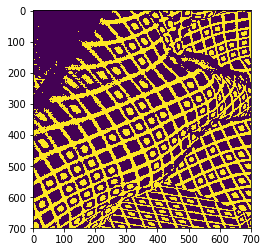

In [10]:
crop = b_img1[1000:1700, 500:1200]
plt.imshow(crop)

In [11]:
skeleton = np.int64(morphology.skeletonize(crop))

In [12]:
%matplotlib inline

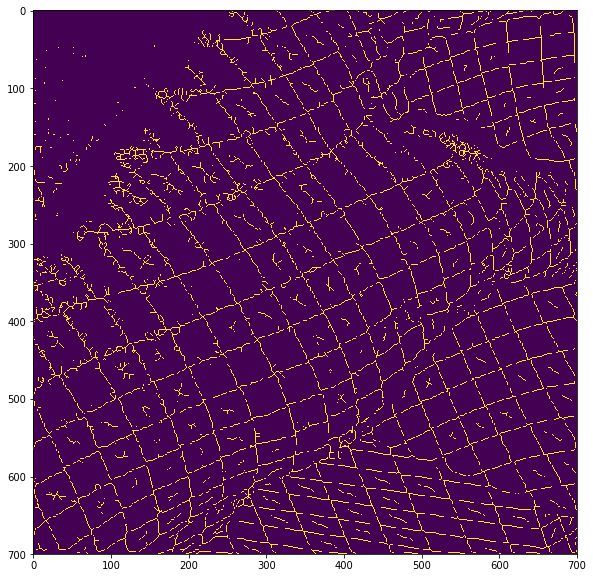

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(skeleton)

In [14]:
from collections import deque

def fill(img, row, col, segment_id):
    Nears = [(-1, 0), (1, 0), (0, 1), (0, -1)]
    
    queue = deque()
    queue.append((row, col))
    img[row, col] = segment_id    
        
    counter = 0
    while len(queue) > 0:
#        if counter % 10000 == 0:
#            print("counter: {}, size: {}".format(counter, len(queue)))
            
        counter += 1
        
        row, col = queue.popleft()
        for dr, dc in Nears:
            r = row + dr
            c = col + dc

            if r < 0 or c < 0 or r >= img.shape[0] or c >= img.shape[1]:
                continue

            if img[r, c] == 0:
                img[r, c] = segment_id
                queue.append((r, c))

In [15]:
def segmentate(img):
    segment_id = 2
    for row in tqdm.tqdm(range(img.shape[0])):
        for col in range(img.shape[1]):
            if img[row, col] == 0:
                fill(img, row, col, segment_id)
                segment_id += 1

In [16]:
segmentate(skeleton)

100%|██████████| 700/700 [00:02<00:00, 253.35it/s]


In [20]:
%matplotlib inline

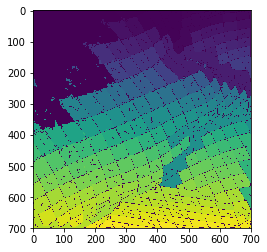

In [21]:
plt.imshow(skeleton)

In [53]:
G = nx.Graph()

In [56]:
G.add_edge(1, 2, w=2)

In [57]:
G.get_edge_data(1, 2)

{'w': 2}

In [58]:
def create_graph(segmentation_map):
    NColors = np.max(segmentation_map) - 1

    G = nx.Graph()
    
    for color in tqdm.tqdm(range(NColors)):
        mask = segmentation_map == color + 2
        rs, cs = np.where(mask)
        
        G.add_node(color + 2, w=np.sum(mask), center_row=np.mean(rs), center_col=np.mean(cs))
       
    Nears = [(-1, 0), (1, 0), (0, 1), (0, -1)]

    for row in tqdm.tqdm(range(segmentation_map.shape[0])):
        for col in range(segmentation_map.shape[1]):
            color_list = []
            
            if segmentation_map[row, col] != 1:
                continue

            for dr, dc in Nears:
                r = row + dr
                c = col + dc
                if r < 0 or c < 0 or r >= segmentation_map.shape[0] or c >= segmentation_map.shape[1]:
                    continue

                color = segmentation_map[r, c]
                if color != 1:
                    color_list.append(color)
                
            if len(color_list) == 1:
                segmentation_map[row, col] = color_list[0]
                
            elif len(color_list) > 1:
                for c1 in color_list:
                    for c2 in color_list:
                        if c1 == c2:
                            continue
                        
                        attr = G.get_edge_data(c1, c2)
                        if attr is None:
                            G.add_edge(c1, c2, w=1)
                        else:
                            G.add_edge(c1, c2, w=attr['w'])
                        
    return G

In [123]:
emb = nx.PlanarEmbedding(G)

In [126]:
import networkx.algorithms.planarity

In [ ]:
networkx.algorithms.planarity.check_planarity

In [113]:
[Gn for n in G.nodes][0]

2

In [119]:
G[2]

AtlasView({3: {'w': 1}, 22: {'w': 1}, 23: {'w': 1}, 24: {'w': 1}, 25: {'w': 1}, 27: {'w': 1}, 28: {'w': 1}, 29: {'w': 1}, 32: {'w': 1}, 43: {'w': 1}, 44: {'w': 1}, 47: {'w': 1}, 49: {'w': 1}, 53: {'w': 1}, 55: {'w': 1}, 57: {'w': 1}, 58: {'w': 1}, 59: {'w': 1}, 60: {'w': 1}, 61: {'w': 1}, 63: {'w': 1}, 64: {'w': 1}, 65: {'w': 1}, 66: {'w': 1}, 67: {'w': 1}, 69: {'w': 1}, 72: {'w': 1}, 71: {'w': 1}, 77: {'w': 1}, 80: {'w': 1}, 86: {'w': 1}, 94: {'w': 1}, 100: {'w': 1}, 101: {'w': 1}, 111: {'w': 1}, 97: {'w': 1}, 113: {'w': 1}, 115: {'w': 1}, 117: {'w': 1}, 118: {'w': 1}, 119: {'w': 1}, 120: {'w': 1}, 121: {'w': 1}, 124: {'w': 1}, 132: {'w': 1}, 133: {'w': 1}, 134: {'w': 1}, 136: {'w': 1}, 135: {'w': 1}, 139: {'w': 1}, 144: {'w': 1}, 147: {'w': 1}, 148: {'w': 1}, 149: {'w': 1}, 150: {'w': 1}, 154: {'w': 1}, 156: {'w': 1}, 157: {'w': 1}, 162: {'w': 1}, 161: {'w': 1}, 163: {'w': 1}, 164: {'w': 1}, 165: {'w': 1}, 169: {'w': 1}, 171: {'w': 1}, 175: {'w': 1}, 173: {'w': 1}, 174: {'w': 1}, 177

In [121]:
G.edges()

EdgeDataView([(2, 3), (2, 22), (2, 23), (2, 24), (2, 25), (2, 27), (2, 28), (2, 29), (2, 32), (2, 43), (2, 44), (2, 47), (2, 49), (2, 53), (2, 55), (2, 57), (2, 58), (2, 59), (2, 60), (2, 61), (2, 63), (2, 64), (2, 65), (2, 66), (2, 67), (2, 69), (2, 72), (2, 71), (2, 77), (2, 80), (2, 86), (2, 94), (2, 100), (2, 101), (2, 111), (2, 97), (2, 113), (2, 115), (2, 117), (2, 118), (2, 119), (2, 120), (2, 121), (2, 124), (2, 132), (2, 133), (2, 134), (2, 136), (2, 135), (2, 139), (2, 144), (2, 147), (2, 148), (2, 149), (2, 150), (2, 154), (2, 156), (2, 157), (2, 162), (2, 161), (2, 163), (2, 164), (2, 165), (2, 169), (2, 171), (2, 175), (2, 173), (2, 174), (2, 177), (2, 178), (2, 180), (2, 182), (2, 183), (2, 188), (2, 189), (2, 176), (2, 190), (2, 191), (2, 192), (2, 193), (2, 194), (2, 195), (2, 197), (2, 198), (2, 205), (2, 206), (2, 208), (2, 213), (2, 215), (2, 216), (2, 217), (2, 218), (2, 219), (2, 222), (2, 224), (2, 230), (2, 235), (2, 245), (2, 249), (2, 251), (2, 253), (2, 254), 

In [108]:
G.nodes[5]

{'w': 63, 'center_row': 1.2222222222222223, 'center_col': 366.968253968254}

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(skeleton)


plt.scatter(Y, X, s=ws / 20)

for row in tqdm.tqdm(range(gm.shape[0])):
    for col in range(gm.shape[1]):
        if row >= col:
            continue
            
        w = gm[row, col]
        if w > 0:
            c1 = row
            c2 = col
            x1 = X[c1]
            x2 = X[c2]
            y1 = Y[c1]
            y2 = Y[c2]
            
            plt.plot([y1, y2], [x1, x2], linewidth=w / 40)

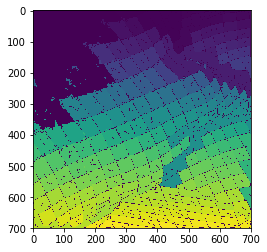

In [59]:
plt.imshow(skeleton)

In [78]:
G.edges(6)


EdgeDataView([(6, 5), (6, 7), (6, 4), (6, 17), (6, 18), (6, 11), (6, 33), (6, 35), (6, 42), (6, 56)])

In [92]:
G.get_edge_data(6, 10)

In [93]:
G.nodes[6]

{'w': 9356, 'center_row': 39.6436511329628, 'center_col': 416.76143651132963}

In [60]:
G = create_graph(skeleton)

100%|██████████| 700/700 [00:00<00:00, 787.85it/s]


In [73]:
nx.check_planarity(G)

(True, <networkx.algorithms.planarity.PlanarEmbedding at 0x7f89947f7fd0>)

/nix/store/q2hxyjdf9hcicilyzxly4dyfyx4i2dcy-python3-3.7.4-env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


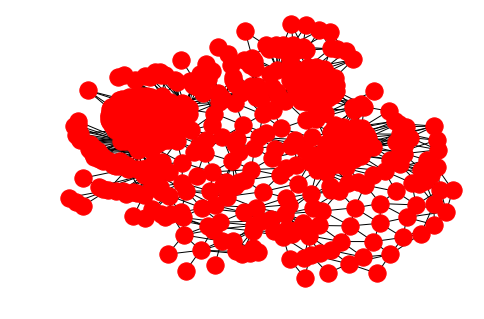

In [74]:
nx.draw_kamada_kawai(G)

In [23]:
gm, ws, X, Y = create_graph(skeleton)

100%|██████████| 700/700 [00:00<00:00, 1078.68it/s]


In [32]:
%matplotlib qt

In [ ]:
plt.li

100%|██████████| 486/486 [00:02<00:00, 181.65it/s]


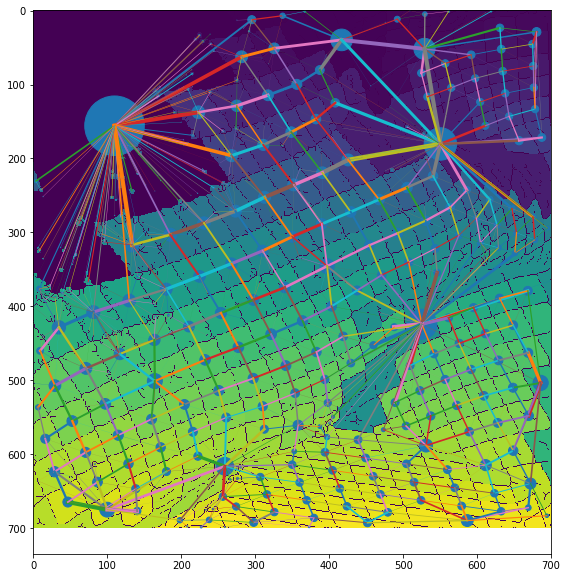

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(skeleton)

plt.scatter(Y, X, s=ws / 20)

for row in tqdm.tqdm(range(gm.shape[0])):
    for col in range(gm.shape[1]):
        if row >= col:
            continue
            
        w = gm[row, col]
        if w > 0:
            c1 = row
            c2 = col
            x1 = X[c1]
            x2 = X[c2]
            y1 = Y[c1]
            y2 = Y[c2]
            
            plt.plot([y1, y2], [x1, x2], linewidth=w / 40)

In [25]:
import networkx as nx

In [26]:
G = nx.Graph()

In [50]:
G.add_node(1, w=10)

In [28]:
G.add_node("Hi")

In [49]:
G.get_edge_data(1, "Hi")

{'v': 2, 'g': 12}

In [48]:
G.add_edge(1, "Hi", v=2)

In [35]:
G.edges()

EdgeView([(1, 2), (1, 'Hi')])

In [19]:
gm.shape

(284, 284)

(array([360., 236.,  96.,  76.,  38.,  22.,  18.,  18.,  10.,  12.,  22.,
         28.,  24.,  22.,  10.,  12.,  12.,   8.,  18.,   6.,  10.,   8.,
          2.,  10.,   2.,   4.,   4.,   0.,   4.,   4.]),
 array([  1.        ,   6.96666667,  12.93333333,  18.9       ,
         24.86666667,  30.83333333,  36.8       ,  42.76666667,
         48.73333333,  54.7       ,  60.66666667,  66.63333333,
         72.6       ,  78.56666667,  84.53333333,  90.5       ,
         96.46666667, 102.43333333, 108.4       , 114.36666667,
        120.33333333, 126.3       , 132.26666667, 138.23333333,
        144.2       , 150.16666667, 156.13333333, 162.1       ,
        168.06666667, 174.03333333, 180.        ]),
 <a list of 30 Patch objects>)

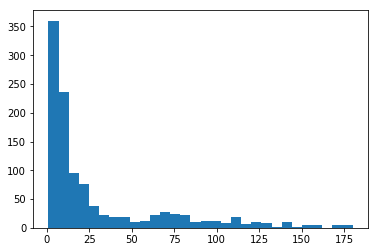

In [23]:
plt.hist(gm[gm != 0], bins=30)

In [ ]:
plt.hist(gm, bins=50)

([array([170.,  12.,  27.,   9.,   8.,   9.,   7.,   8.,   7.,   4.,   4.,
           5.,   0.,   3.,   1.,   0.,   2.,   0.,   3.,   0.,   1.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   1.,   1.]),
  array([277.,   1.,   2.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
           0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.]),
  array([280.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
      

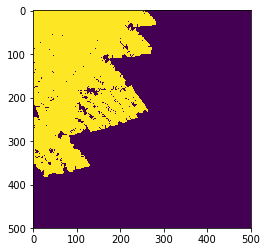

In [164]:
plt.imshow(skeleton==2)

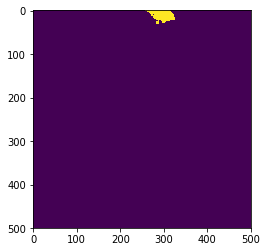

In [165]:
plt.imshow(skeleton==3)

In [124]:
plt.imshow(skeleton)

In [135]:
np.max(skeleton)

285

In [136]:
285**2

81225

In [134]:
plt.imshow(skeleton == 1000)

In [123]:
%matplotlib qt

In [92]:
plt.imsave("./images/seg1.png", skeleton)

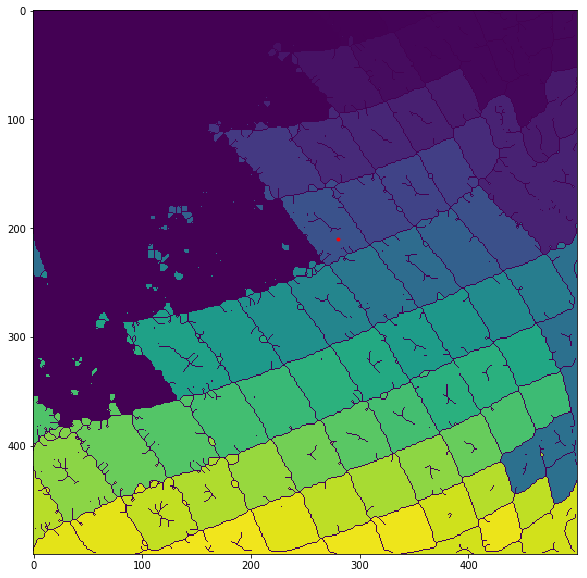

In [75]:
plt.figure(figsize=(10,10))
plt.imshow(skeleton)
plt.plot(280, 210, '.', c='r')


In [68]:
skeleton.dtype

dtype('bool')

In [53]:
fill(skeleton, 210, 300, 2)

counter: 0, size: 1


In [ ]:
plt.im

In [18]:
morphology.max_tree

AttributeError: module 'skimage.morphology' has no attribute 'max_tree'

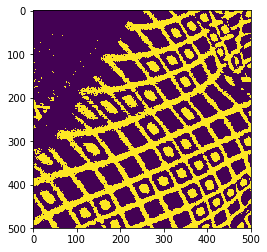

In [282]:
crop1 = b_img1[1000:1500, 500:1000]
plt.imshow(crop1)

In [284]:
pow

<function pow(x, y, z=None, /)>

In [285]:
def apply_pow(f, n):
    if n == 0:
        return f
    else:
        return lambda v: f (apply_pow(f, n-1)(v))

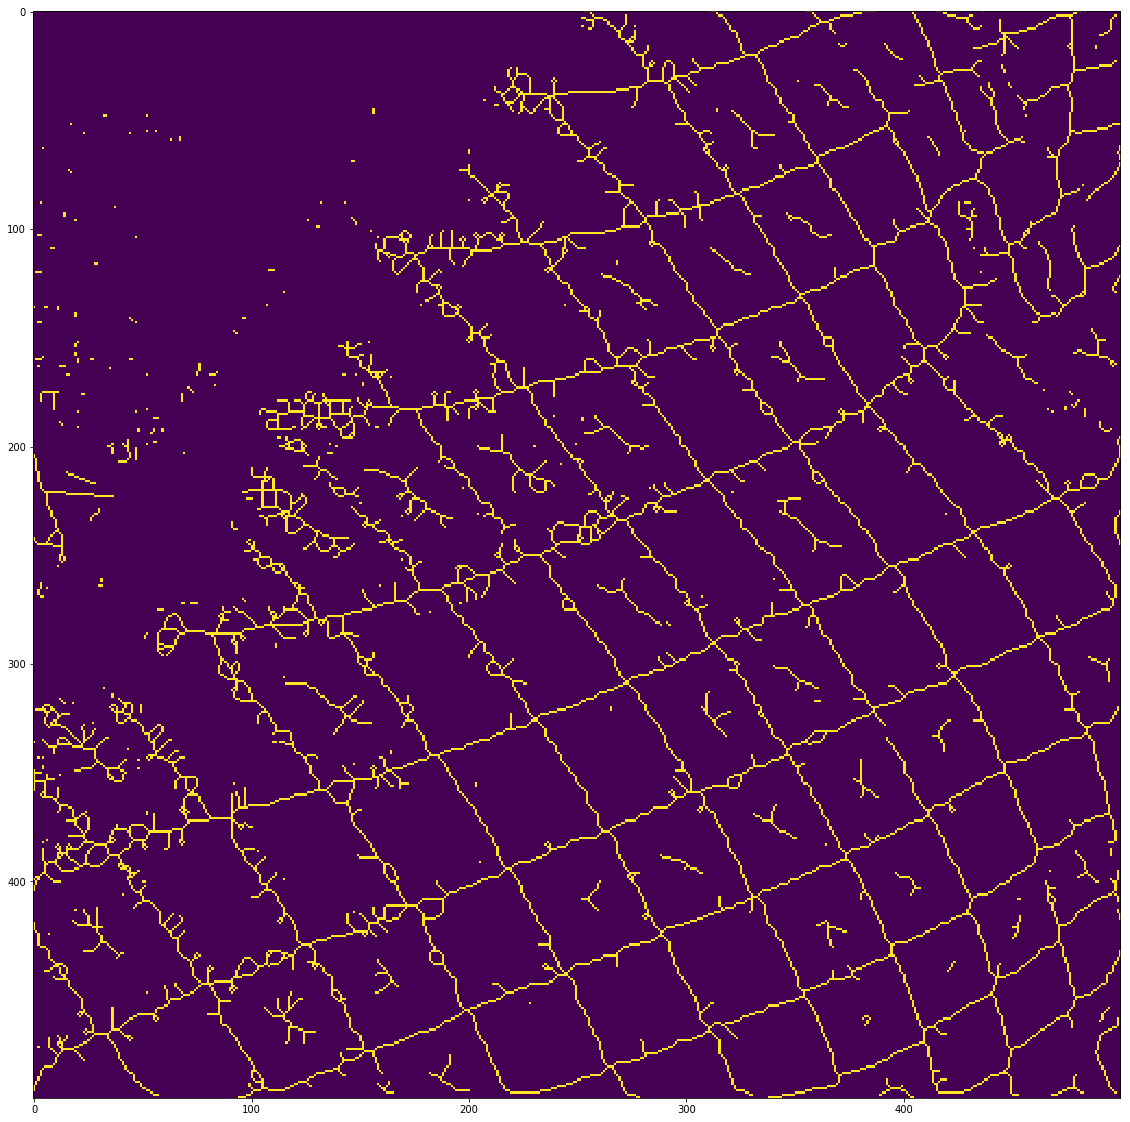

In [311]:
plt.figure(figsize=(20,20))
plt.imshow(skeletonize(crop1))

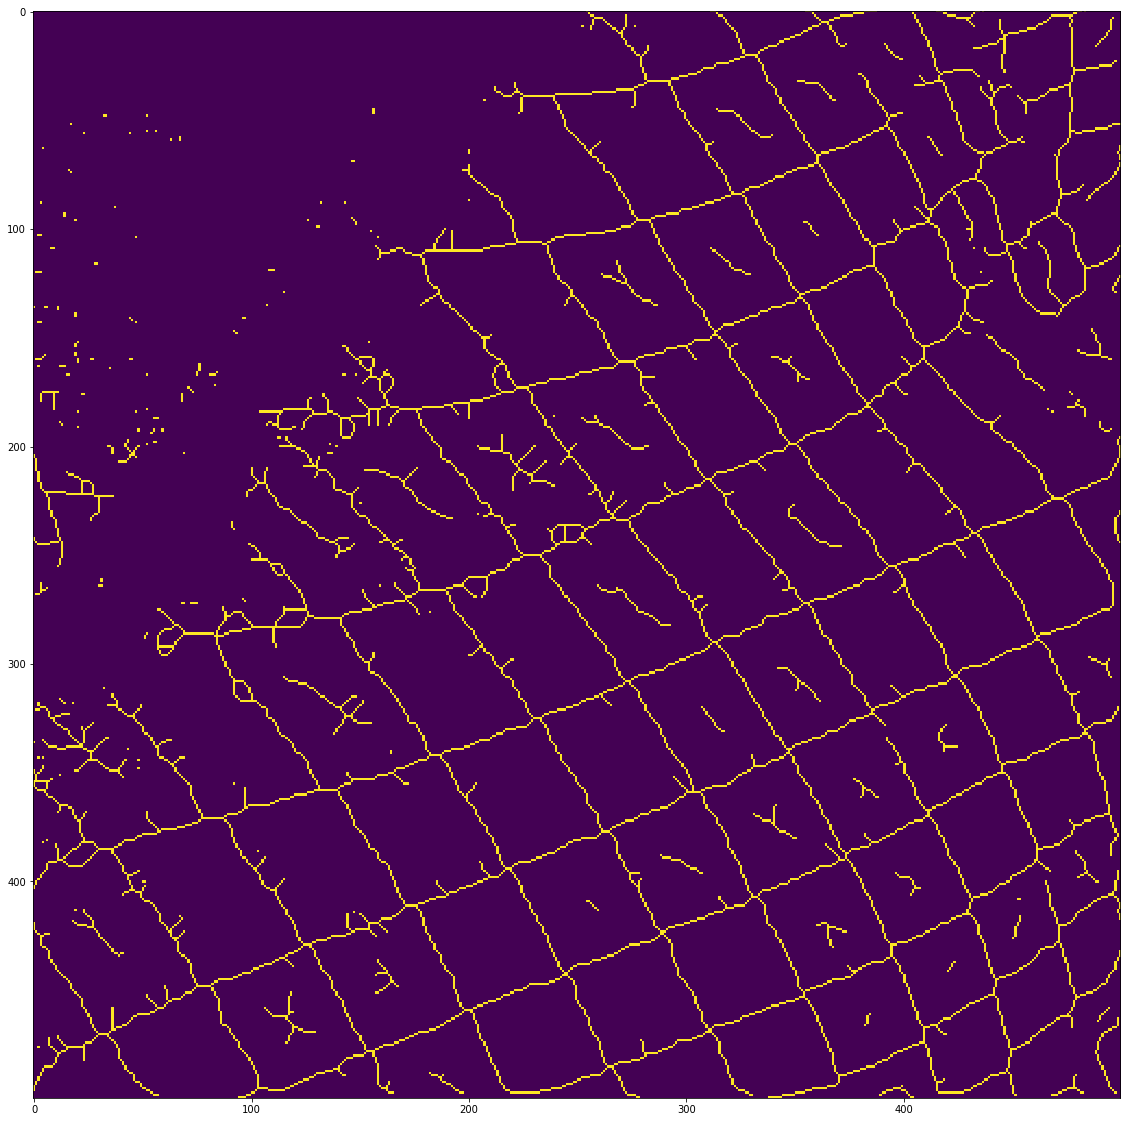

In [312]:
plt.figure(figsize=(20,20))
plt.imshow(skeletonize(apply_pow(skimage.morphology.closing, 100)(crop1)))

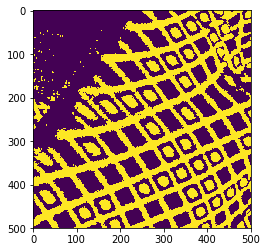

In [283]:
plt.imshow(skimage.morphology.dilation(crop1))

In [276]:
from skimage.morphology import skeletonize

In [281]:
import skimage.morphology

In [280]:
plt.imsave("./images/skeleton.png", skeletonize(b_img1))

In [84]:
%matplotlib inline

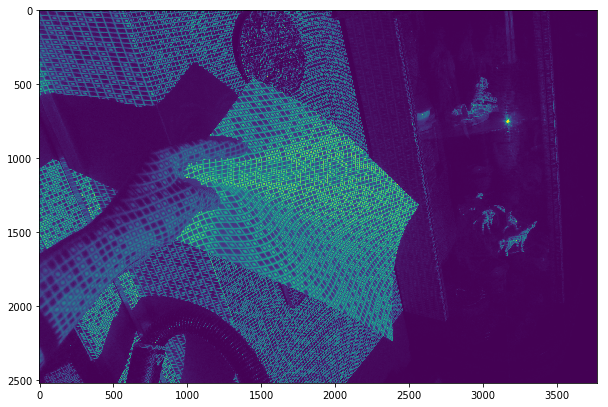

In [86]:
plt.figure(figsize=(10,10))
plt.imshow(img1)

In [139]:
from collections import deque

Nears = [(-1, 0), (1, 0), (0, 1), (0, -1)]
def eval_distances(energy_map, start_points):
    distance_map = np.empty_like(energy_map, dtype=np.float64)
    distance_map[:] = np.infty
    queue = deque()
    for p in start_points:
        queue.append(p)
        distance_map[p[0], p[1]] = 0
        
    counter = 0
    while len(queue) > 0:
        if counter % 10000 == 0:
            print("counter: {}, size: {}".format(counter, len(queue)))
            
        counter += 1
        
        row, col = queue.popleft()
        for dr, dc in Nears:
            r = row + dr
            c = col + dc

            if r < 0 or c < 0 or r >= energy_map.shape[0] or c >= energy_map.shape[1]:
                continue

            v = distance_map[row, col] + energy_map[r, c]
            if v < distance_map[r, c]:
                distance_map[r, c] = v
                queue.append((r, c))
    
    return distance_map

In [216]:
def eval_trajectory(distance_map, start_point):
    trajectory = [start_point]
    row, col = start_point
    counter = 10000
    while distance_map[row, col] > 0 and counter > 0:
        v = np.infty
        for dr, dc in Nears:
            r = row + dr
            c = col + dc

            if r < 0 or c < 0 or r >= distance_map.shape[0] or c >= distance_map.shape[1]:
                continue

            if distance_map[r, c] < v:
                v = distance_map[r, c]
                new_r = r
                new_c = c
        
        row = new_r
        col = new_c
        trajectory.append((row, col))
        counter -= 1
    
    return trajectory, counter

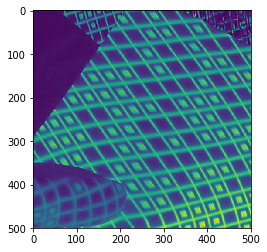

In [188]:
crop1 = img1[500:1000, 1200:1700]
plt.imshow(crop1)

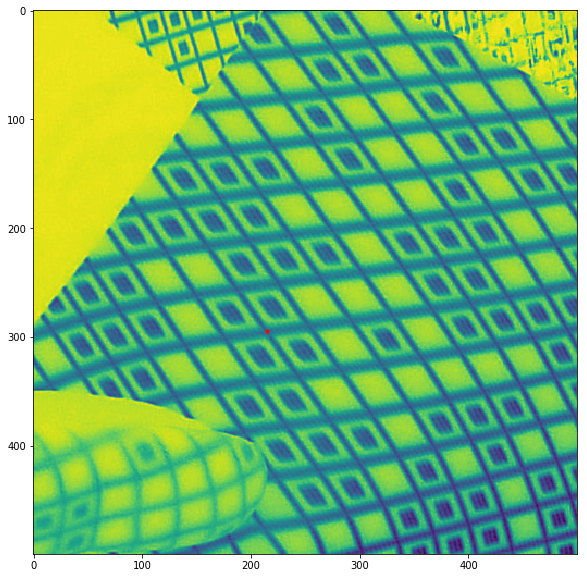

In [213]:
img = 1 + crop1.max() - crop1
plt.figure(figsize=(10,10))
plt.imshow(img)
P = (295, 215)
plt.plot(P[1], P[0], '.', c='r')

In [214]:
d_map = eval_distances(img, [P])

counter: 0, size: 1
counter: 10000, size: 425
counter: 20000, size: 721
counter: 30000, size: 1020
counter: 40000, size: 1156
counter: 50000, size: 1333
counter: 60000, size: 1509
counter: 70000, size: 1636
counter: 80000, size: 1885
counter: 90000, size: 2088
counter: 100000, size: 2234
counter: 110000, size: 2331
counter: 120000, size: 2409
counter: 130000, size: 2494
counter: 140000, size: 2599
counter: 150000, size: 2713
counter: 160000, size: 2776
counter: 170000, size: 2890
counter: 180000, size: 3015
counter: 190000, size: 3111
counter: 200000, size: 3229
counter: 210000, size: 3366
counter: 220000, size: 3503
counter: 230000, size: 3652
counter: 240000, size: 3812
counter: 250000, size: 3884
counter: 260000, size: 3988
counter: 270000, size: 4077
counter: 280000, size: 4182
counter: 290000, size: 4264
counter: 300000, size: 4389
counter: 310000, size: 4512
counter: 320000, size: 4599
counter: 330000, size: 4721
counter: 340000, size: 4841
counter: 350000, size: 4920
counter: 36

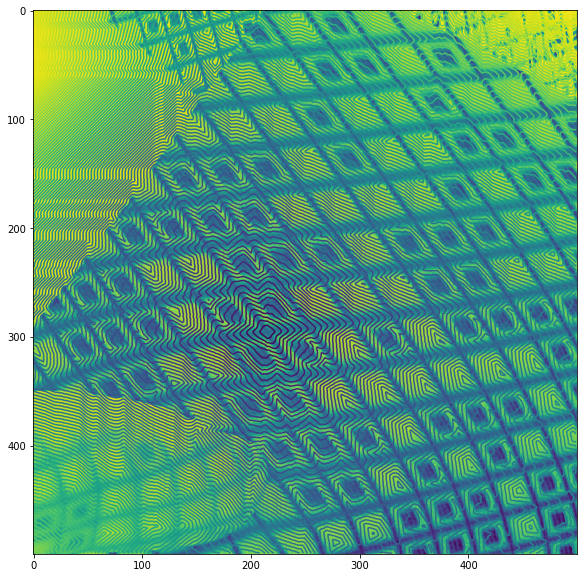

In [215]:
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.contour(d_map, levels=100)

In [228]:
import tqdm

tr_map = np.zeros_like(d_map)
for start_p in tqdm.tqdm(np.int64(np.random.uniform(low=[0,0], high=d_map.shape, size=(1000, 2)))):
    # print(start_p)
    trajectory, counter = eval_trajectory(d_map, start_p)
    if counter == 0:
        print(start_p)
    for p in trajectory:
        tr_map[p[0], p[1]] += 1


100%|██████████| 1000/1000 [00:04<00:00, 214.09it/s]

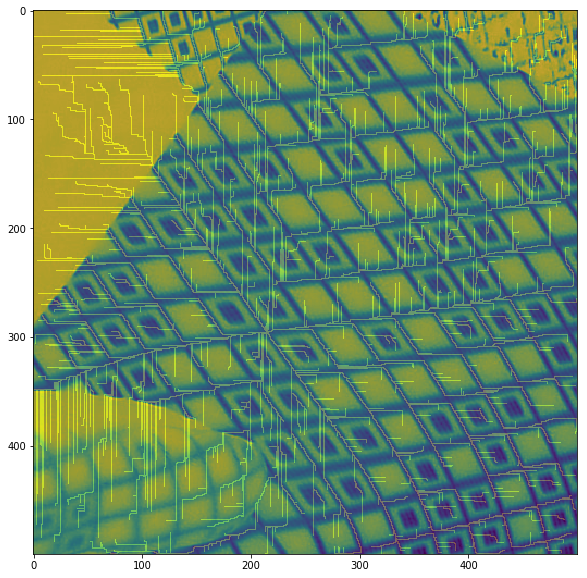

In [229]:
plt.figure(figsize=(10,10))
plt.imshow(img)
#plt.contour(d_map, levels=100)
plt.imshow(tr_map> 0, alpha=0.3)

In [267]:
from collections import deque

Nears = [(-1, 0), (1, 0), (0, 1), (0, -1)]
def fill(image, start_points, eps=3):
    f_image = np.zeros_like(image, dtype=np.float64)
    
    queue = deque()
    for p in start_points:
        queue.append(p)
        f_image[p[0], p[1]] = 1
        
    counter = 0
    while len(queue) > 0:
        if counter % 10000 == 0:
            print("counter: {}, size: {}".format(counter, len(queue)))
            
        counter += 1
        
        row, col = queue.popleft()
        for dr, dc in Nears:
            r = row + dr
            c = col + dc

            if r < 0 or c < 0 or r >= image.shape[0] or c >= image.shape[1]:
                continue

            if np.abs(image[row, col] - image[r, c]) < eps:
                if f_image[r, c] == 0:
                    f_image[r, c] = counter
                    queue.append((r, c))
    
    return f_image

counter: 0, size: 1
counter: 10000, size: 200
counter: 20000, size: 299
counter: 30000, size: 331
counter: 40000, size: 350
counter: 50000, size: 452
counter: 60000, size: 606
counter: 70000, size: 614
counter: 80000, size: 623
counter: 90000, size: 513
counter: 100000, size: 555
counter: 110000, size: 596
counter: 120000, size: 542
counter: 130000, size: 528
counter: 140000, size: 366
counter: 150000, size: 280
counter: 160000, size: 180
counter: 170000, size: 79
counter: 180000, size: 108


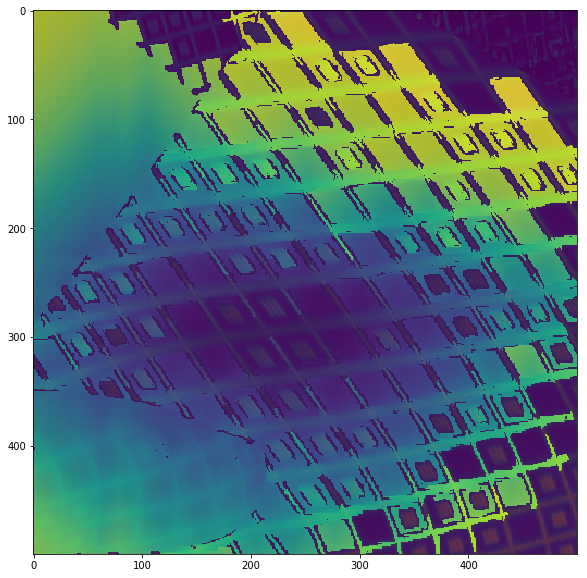

In [269]:
plt.figure(figsize=(10,10))
plt.imshow(crop1)
plt.imshow(fill(crop1, [P], eps=10), alpha=0.8)

In [131]:
np.percentile(crop1, 90)

81.33333333333333

In [132]:
np.percentile(crop1, 10)

22.333333333333332

In [141]:
crop1.shape

(200, 200)

In [142]:
s_crop1 = np.copy(crop1)

In [143]:
s_crop1.shape

(200, 200)

In [145]:
s_crop1 = s_crop1 - np.percentile(crop1, 10)

In [146]:
s_crop1.shape

(200, 200)

In [150]:
s_crop1 = np.maximum(s_crop1, 0)

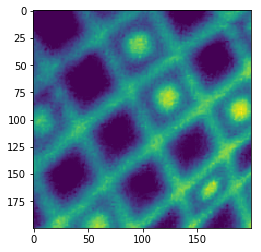

In [151]:
plt.imshow(s_crop1)

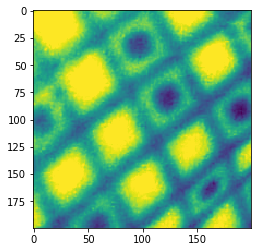

In [154]:
plt.imshow(1 + np.max(s_crop1) - s_crop1)

In [139]:
s_crop1 = s_crop1 - np.percentile(crop1, 10)

In [140]:
s_crop1.shape

(200,)

In [135]:
s_crop1 = np.max(s_crop1, 0)

In [138]:
s_crop1.shape

(200,)

TypeError: Invalid dimensions for image data

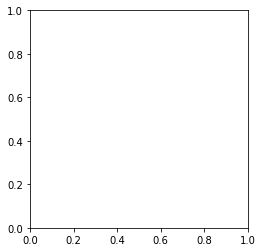

In [137]:
plt.imshow(s_crop1)

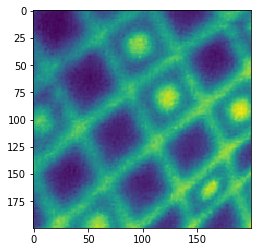

In [130]:
plt.imshow(crop1 / np.percentile(crop1, 50))

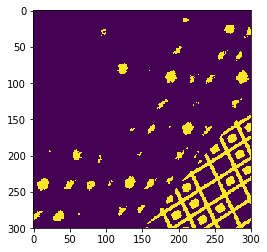

In [125]:
plt.imshow(crop1 > np.percentile(crop1, 90))

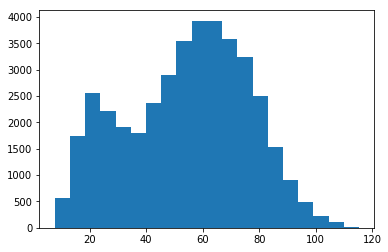

In [99]:
plt.hist(crop1.reshape(-1), bins=20);

In [103]:
np.percentile([1,2,3,4,5], 90)

4.6

In [98]:
crop1.reshape(-1)

array([ 32.        ,  30.66666667,  28.66666667, ...,  90.66666667,
        95.66666667, 100.66666667])

In [82]:
plt.imsave("./images/img1.png", binarize(img1))
plt.imsave("./images/img2.png", binarize(img2))

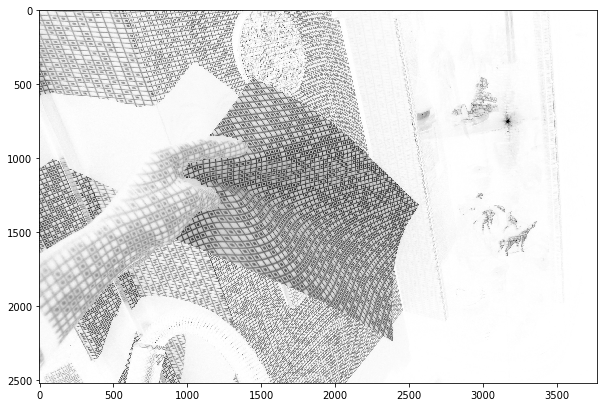

In [2]:
invert_image = 256 - gray_image

plt.figure(figsize=(10,10))
plt.imshow(invert_image, cm.gray)

In [2]:
import skimage

In [59]:
f_img = skimage.filters.gaussian(gray_image, 10)

In [4]:
%matplotlib inline

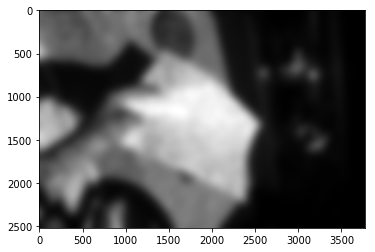

In [5]:
plt.imshow(f_img, cm.gray)

In [31]:
%matplotlib qt

In [76]:
mask = (gray_image > f_img) & (gray_image > 8)

In [77]:
plt.imsave("./images/binary.png", mask)

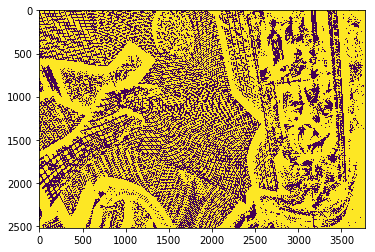

In [8]:
invert_image = 1 - (gray_image > f_img)
plt.imshow(invert_image)

In [9]:
from collections import deque

Nears = [(-1, 0), (1, 0), (0, 1), (0, -1)]
def eval_distances(energy_map, start_points):
    distance_map = np.empty_like(energy_map, dtype=np.float64)
    distance_map[:] = np.infty
    queue = deque()
    for p in start_points:
        queue.append(p)
        distance_map[p[0], p[1]] = 0
        
    counter = 0
    while len(queue) > 0:
        if counter % 10000 == 0:
            print("counter: {}, size: {}".format(counter, len(queue)))
            
        counter += 1
        
        row, col = queue.popleft()
        for dr, dc in Nears:
            r = row + dr
            c = col + dc

            if r < 0 or c < 0 or r >= energy_map.shape[0] or c >= energy_map.shape[1]:
                continue

            v = distance_map[row, col] + energy_map[r, c]
            if v < distance_map[r, c]:
                distance_map[r, c] = v
                queue.append((r, c))
    
    return distance_map

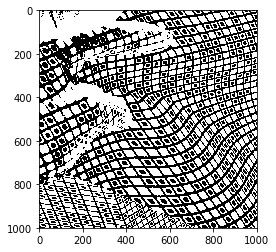

In [12]:
img = invert_image[800:1800, 800:1800]
plt.imshow(img, cm.gray)

In [29]:
img = 100 * invert_image[1000:1300, 1000:1300] + 1
plt.imshow(img, cm.gray)

In [30]:
d = eval_distances(img, [(0, i) for i in range(img.shape[1])])

counter: 0, size: 300
counter: 10000, size: 765
counter: 20000, size: 1065
counter: 30000, size: 1211
counter: 40000, size: 1179
counter: 50000, size: 1266
counter: 60000, size: 1297
counter: 70000, size: 1416
counter: 80000, size: 1498
counter: 90000, size: 1598
counter: 100000, size: 1663
counter: 110000, size: 1872
counter: 120000, size: 1948
counter: 130000, size: 2062
counter: 140000, size: 2133
counter: 150000, size: 2050
counter: 160000, size: 2167
counter: 170000, size: 2229
counter: 180000, size: 2273
counter: 190000, size: 2274
counter: 200000, size: 2386
counter: 210000, size: 2239
counter: 220000, size: 2290
counter: 230000, size: 2333
counter: 240000, size: 2335
counter: 250000, size: 2471
counter: 260000, size: 2422
counter: 270000, size: 2440
counter: 280000, size: 2476
counter: 290000, size: 2486
counter: 300000, size: 2501
counter: 310000, size: 2577
counter: 320000, size: 2564
counter: 330000, size: 2525
counter: 340000, size: 2510
counter: 350000, size: 2559
counter:

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(d)
#plt.imshow(img, cm.gray, alpha=0.1)

In [32]:
def eval_trajectory(distance_map, start_point):
    trajectory = [start_point]
    row, col = start_point
    counter = 10000
    while distance_map[row, col] > 0 and counter > 0:
        v = np.infty
        for dr, dc in Nears:
            r = row + dr
            c = col + dc

            if r < 0 or c < 0 or r >= distance_map.shape[0] or c >= distance_map.shape[1]:
                continue

            if distance_map[r, c] < v:
                v = distance_map[r, c]
                new_r = r
                new_c = c
        
        row = new_r
        col = new_c
        trajectory.append((row, col))
        counter -= 1
    
    return trajectory, counter

In [39]:
import tqdm

tr_map = np.zeros_like(d)
for start_p in tqdm.tqdm(np.int64(np.random.uniform(low=[0,0], high=d.shape, size=(10000, 2)))):
    # print(start_p)
    trajectory, counter = eval_trajectory(d, start_p)
    if counter == 0:
        print(start_p)
    for p in trajectory:
        tr_map[p[0], p[1]] += 1


 61%|██████    | 6111/10000 [00:31<00:22, 176.23it/s]


100%|██████████| 10000/10000 [00:51<00:00, 193.48it/s]

In [34]:

plt.imshow(tr_map)
plt.imshow(d, alpha=0.5)

In [27]:
%matplotlib qt

In [43]:
plt.imshow(img, cm.gray)
plt.imshow(tr_map > 10, alpha=0.6)

In [51]:
eval_trajectory(d, (100,100))

[(100, 100),
 (99, 101),
 (98, 102),
 (97, 103),
 (96, 104),
 (95, 105),
 (94, 106),
 (93, 107),
 (92, 108),
 (91, 109),
 (90, 110),
 (89, 111),
 (88, 112),
 (87, 113),
 (86, 114),
 (85, 114),
 (84, 114),
 (83, 115),
 (82, 114),
 (81, 114),
 (80, 113),
 (79, 114),
 (78, 114),
 (77, 114),
 (76, 114),
 (75, 113),
 (74, 113),
 (73, 113),
 (72, 113),
 (71, 113),
 (70, 113),
 (69, 112),
 (68, 112),
 (67, 112),
 (66, 112),
 (65, 112),
 (64, 112),
 (63, 112),
 (62, 112),
 (61, 112),
 (60, 112),
 (59, 111),
 (58, 112),
 (57, 112),
 (56, 111),
 (55, 111),
 (54, 111),
 (53, 111),
 (52, 111),
 (51, 111),
 (50, 111),
 (49, 111),
 (48, 111),
 (47, 111),
 (46, 111),
 (45, 111),
 (44, 111),
 (43, 111),
 (42, 111),
 (41, 112),
 (40, 111),
 (39, 110),
 (38, 110),
 (37, 110),
 (36, 109),
 (35, 109),
 (34, 110),
 (33, 110),
 (32, 111),
 (31, 111),
 (30, 110),
 (29, 110),
 (28, 110),
 (27, 109),
 (26, 110),
 (25, 111),
 (24, 111),
 (23, 110),
 (22, 110),
 (21, 109),
 (20, 108),
 (19, 108),
 (18, 109),
 (1